In [1]:
from datasets.memmap_dataset import MemMapSpatioTemporalDataset
from models.spatiotemporal_model import SpatioTemporalModel
from models.lightning_base import LightningBase
from tqdm.auto import tqdm
import torch
import os

# Training
train_path = "data/sub_2CMEMS-MEDSEA-2010-2016-training.nc.bin"
test_path = "data/sub_2CMEMS-MEDSEA-2017-testing.nc.bin"
use_cuda = torch.cuda.is_available()
batch_size = 128
num_workers = 8

# Experiment

num_cnn_layers = 3
num_lstm_layers = 2
num_fc_layers = 4
hidden_size = 128

# defines the dimensions of the neighborhood
# a neghborhood of size 1 means that the axis is not considered.
# preferably, the neighborhood size should be odd
lat_neghborhood_size = 1
lon_neghborhood_size = 1
depth_neghborhood_size = 11

with_position_embedding = True

experiment_name = f"spatio_temporal_model_\
{num_cnn_layers}_\
{num_lstm_layers}_\
{num_fc_layers}_\
{hidden_size}_\
{lat_neghborhood_size}_\
{lon_neghborhood_size}_\
{depth_neghborhood_size}_\
{'with_position_embedding' if with_position_embedding else 'without_position_embedding'}"


try:
    ckpt = os.listdir(f"checkpoints/{experiment_name}")[-1]
    ckpt = f"checkpoints/{experiment_name}/{ckpt}"
    print("Submitting with checkpoint", ckpt)
except:
    print("No checkpoint with this configuration found.")
    ckpt = None

No checkpoint with this configuration found.


In [2]:
valid_dataset = MemMapSpatioTemporalDataset(
    bin_path=train_path,
    train=True,
    valid=True,
    valid_interval_length=365,
    lat_neghborhood_size=lat_neghborhood_size,
    lon_neghborhood_size=lon_neghborhood_size,
    depth_neghborhood_size=depth_neghborhood_size,
    overwrite_index=False,
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

In [3]:
model = SpatioTemporalModel(
    features_size=valid_dataset.nfeatures,
    hidden_size=hidden_size,
    targets_size=valid_dataset.ntargets,

    num_cnn_layers=num_cnn_layers,
    num_lstm_layers=num_lstm_layers,
    num_fc_layers=num_fc_layers,

    lat_neghborhood_size=lat_neghborhood_size,
    lon_neghborhood_size=lon_neghborhood_size,
    depth_neghborhood_size=depth_neghborhood_size,

    with_position_embedding=with_position_embedding,
    lat_size=valid_dataset.nlatitudes,
    lon_size=valid_dataset.nlongitudes,
    depth_size=valid_dataset.ndepths,
).to('cuda' if use_cuda else 'cpu').eval()

if ckpt is not None:
    model = LightningBase.load_from_checkpoint(
        model=model,
        checkpoint_path=ckpt
    ).eval()
else:
    print("No checkpoint found, using random weights.")
    model = LightningBase(
        model=model
    ).eval()

No checkpoint found, using random weights.


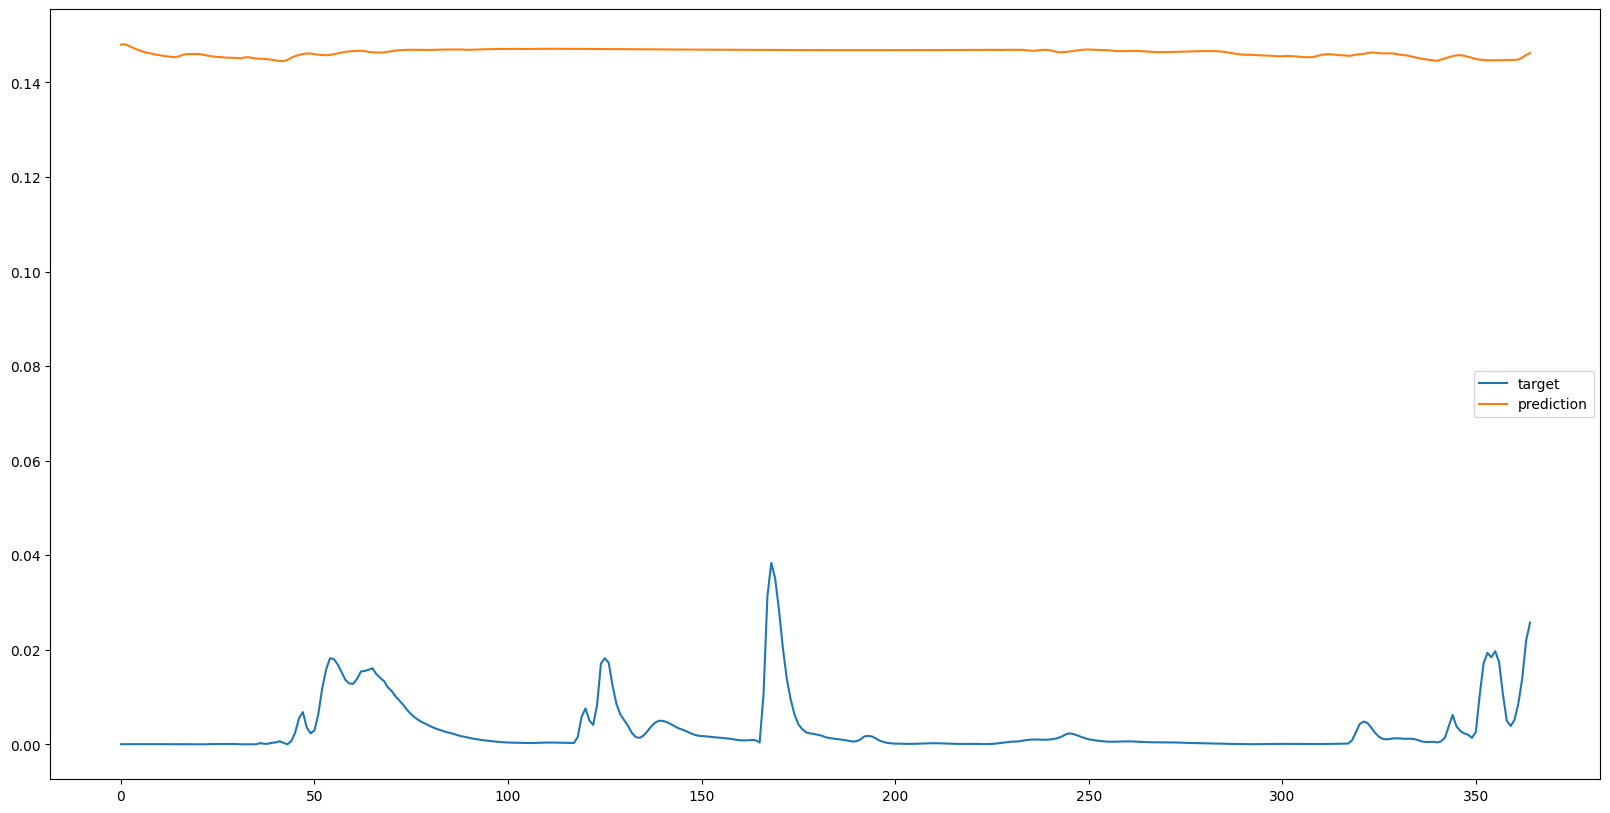

In [4]:
# plot the prediction vs the target
import matplotlib.pyplot as plt
import numpy as np

rand_idx = np.random.randint(0, len(valid_dataset))
valid_position, valid_features, valid_targets = valid_dataset[rand_idx]

valid_position = valid_position.unsqueeze(0).to(model.device)
valid_features = valid_features.unsqueeze(0).to(model.device)
valid_targets = valid_targets.unsqueeze(0).to(model.device)

valid_prediction = model(valid_position, valid_features)

valid_position = valid_position.cpu().detach().numpy()
valid_features = valid_features.cpu().detach().numpy()
valid_targets = valid_targets.cpu().detach().numpy()
valid_prediction = valid_prediction.cpu().detach().numpy()

# plot the prediction vs the target

plt.figure(figsize=(20, 10))
plt.plot(valid_targets[0, :, 0], label="target")
plt.plot(valid_prediction[0, :, 0], label="prediction")
plt.legend()
plt.show()

A Jupyter Widget

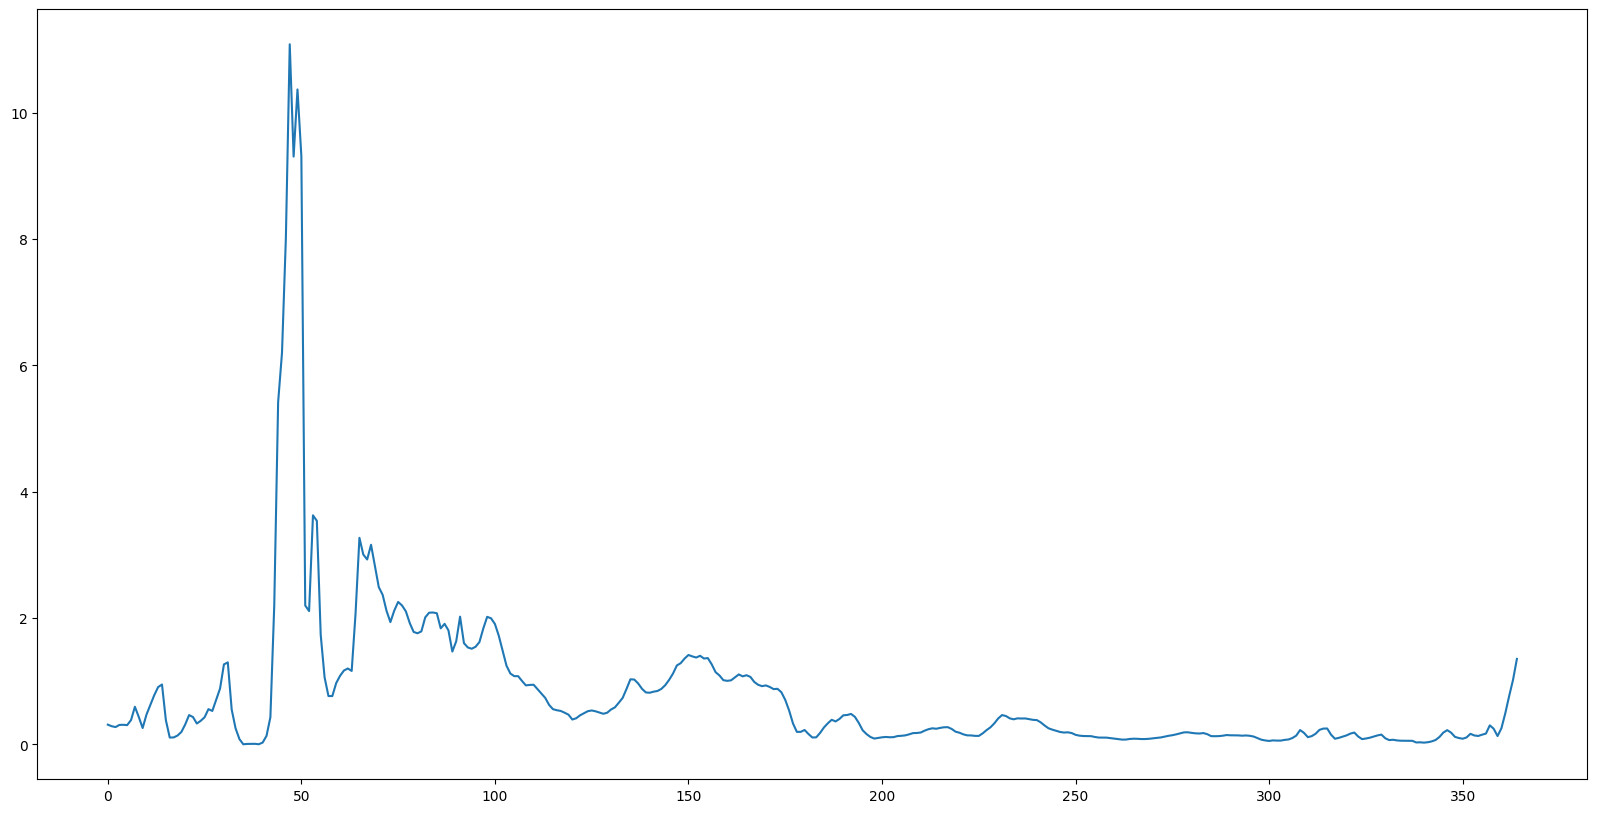

In [24]:
# plot the square error error over the whole dataset to discover bottlenecks
import numpy as np

predictions = []
targets = []

for i, (position, features, target) in tqdm(enumerate(valid_dataset)):
    position = position.unsqueeze(0).to(model.device)
    features = features.unsqueeze(0).to(model.device)
    target = target.unsqueeze(0).to(model.device)

    prediction = model(position, features)

    predictions.append(prediction.cpu().detach().numpy())
    targets.append(target.cpu().detach().numpy())
    
    if i == 10:
        break

predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

plt.figure(figsize=(20, 10))
plt.plot(((predictions - targets) ** 2).mean(axis=0))
plt.show()